In [1]:
from __future__ import division, print_function

In [2]:
import numpy as np
import mmd

## Generate fake data
As an example, let's regress 1d normals to their mean.

We're storing the data as a list of `n` numpy arrays, each of size `n_samp x dim` (with `dim == 1`).

In [3]:
n = 500
mean = np.random.normal(0, 10, size=n)
var = np.random.gamma(5, size=n)
n_samp = np.random.randint(10, 500, size=n)
samps = [np.random.normal(m, v, size=s)[:, np.newaxis]
         for m, v, s in zip(mean, var, n_samp)]

In [4]:
# this gives us a progress bar for MMD computations
from mmd.utils import show_progress
show_progress('mmd.mmd.progress')

In [5]:
# Get the median pairwise squared distance in the aggregate sample,
# as a heuristic for choosing the bandwidth of the inner RBF kernel.
from sklearn.metrics.pairwise import euclidean_distances
sub = np.vstack(samps)
sub = sub[np.random.choice(sub.shape[0], min(1000, sub.shape[0]), replace=False)]
D2 = euclidean_distances(sub, squared=True)
med_2 = np.median(D2[np.triu_indices_from(D2, k=1)], overwrite_input=True)
del sub, D2

In [6]:
from sklearn import cross_validation as cv
from sklearn.kernel_ridge import KernelRidge
import sys

In [7]:
l1_gamma_mults = np.array([1/16, 1/4, 1, 4])  # Could expand these, but it's quicker if you don't. :)
l1_gammas = l1_gamma_mults * med_2

Now we'll get the $\mathrm{MMD}^2$ values for each of the proposed gammas.
(This is maybe somewhat faster than doing it independently, but I haven't
really tested that; if it's causing memory issues or anything, do them separately.)

We also want to save the "diagonal" values (the mean map kernel between a set
and itself), so we can compute the MMD to test values later without recomputing
those.

In [8]:
mmds, mmk_diags = mmd.rbf_mmd(samps, gammas=l1_gammas, squared=True, n_jobs=40, ret_X_diag=True)

RBF mean map kernel:
 125,250 of 125,250 (100%) |###########################################################| Time: 0:02:11



Now, we want to turn this into a kernel and evaluate the regression
for each of the other hyperparameter values.

We'll just do a 3d grid search here.

Ideally, this would be:

- Parallelized. Scikit-learn's tools for this want to pickle the kernels, which is a non-starter here. It'd take some coding to work around that.
- Not a grid search. It's harder to get away from grid search for the l1 gamma because it's kind of expensive, but you could definitely do a randomized search (or some kind of actual optimization) for the l2 gamma + alpha parameters.
- Really, KernelRidge should support leave-one-out CV across a bunch of alphas, like RidgeCV. [Supposedly this isn't too hard](https://github.com/scikit-learn/scikit-learn/pull/3942#issuecomment-179570126) but I haven't spent the time to try to figure it out, and apparently neither has anyone else. This would help with the parallelization issue.

In [9]:
# Choose parameters for the hyperparameter search
k_fold = list(cv.KFold(n, n_folds=3, shuffle=True))

l2_gamma_mults = np.array([1/4, 1, 4, 8])
alphas = np.array([1/128, 1/64, 1/16, 1/4, 1, 4])

scores = np.empty((l1_gamma_mults.size, l2_gamma_mults.size, alphas.size, len(k_fold)))
scores.fill(np.nan)

In [10]:
%%time

K = np.empty((n, n), dtype=samps[0].dtype)
for l1_gamma_i, l1_gamma in enumerate(l1_gamma_mults * med_2):
    print("l1 gamma {} / {}: {:.4}".format(l1_gamma_i + 1, len(l1_gamma_mults), l1_gamma), file=sys.stderr)
    D2_mmd = mmds[l1_gamma_i]
    
    # get the median of *these* squared distances,
    # to scale the bandwidth of the outer RBF kernel
    mmd_med2 = np.median(D2_mmd[np.triu_indices_from(D2_mmd, k=1)])
    
    for l2_gamma_i, l2_gamma in enumerate(l2_gamma_mults * mmd_med2):
        print("\tl2 gamma {} / {}: {:.4}".format(l2_gamma_i + 1, len(l2_gamma_mults), l2_gamma), file=sys.stderr)
        np.multiply(D2_mmd, -l2_gamma, out=K)
        np.exp(K, out=K)
        
        for alpha_i, alpha in enumerate(alphas):
            ridge = KernelRidge(alpha=alpha, kernel='precomputed')
            these = cv.cross_val_score(ridge, K, mean, cv=k_fold)
            scores[l1_gamma_i, l2_gamma_i, alpha_i, :] = these
            print("\t\talpha {} / {}: {} \t {}".format(alpha_i + 1, len(alphas), alpha, these), file=sys.stderr)

l1 gamma 1 / 4: 7.562
	l2 gamma 1 / 4: 0.01677
		alpha 1 / 6: 0.0078125 	 [ 0.9253348   0.91112741  0.92746963]
		alpha 2 / 6: 0.015625 	 [ 0.86428587  0.83874947  0.87861644]
		alpha 3 / 6: 0.0625 	 [ 0.64522929  0.60369467  0.67002685]
		alpha 4 / 6: 0.25 	 [ 0.33072326  0.29631131  0.34359958]
		alpha 5 / 6: 1.0 	 [ 0.10770497  0.08482278  0.11357141]
		alpha 6 / 6: 4.0 	 [ 0.02324835  0.005496    0.02778346]
	l2 gamma 2 / 4: 0.06708
		alpha 1 / 6: 0.0078125 	 [ 0.98203002  0.9805339   0.96849574]
		alpha 2 / 6: 0.015625 	 [ 0.96198555  0.95618912  0.95410813]
		alpha 3 / 6: 0.0625 	 [ 0.86382546  0.83823775  0.87833251]
		alpha 4 / 6: 0.25 	 [ 0.64438717  0.60291489  0.66924618]
		alpha 5 / 6: 1.0 	 [ 0.32986607  0.29558004  0.34272459]
		alpha 6 / 6: 4.0 	 [ 0.10734844  0.08462546  0.11317859]
	l2 gamma 3 / 4: 0.2683
		alpha 1 / 6: 0.0078125 	 [ 0.99543429  0.99579355  0.9813862 ]
		alpha 2 / 6: 0.015625 	 [ 0.99145241  0.99138094  0.97655579]
		alpha 3 / 6: 0.0625 	 [ 0.9612365  

CPU times: user 28.1 s, sys: 22.9 s, total: 51 s
Wall time: 3.79 s


In [11]:
mean_scores = scores.mean(axis=-1)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

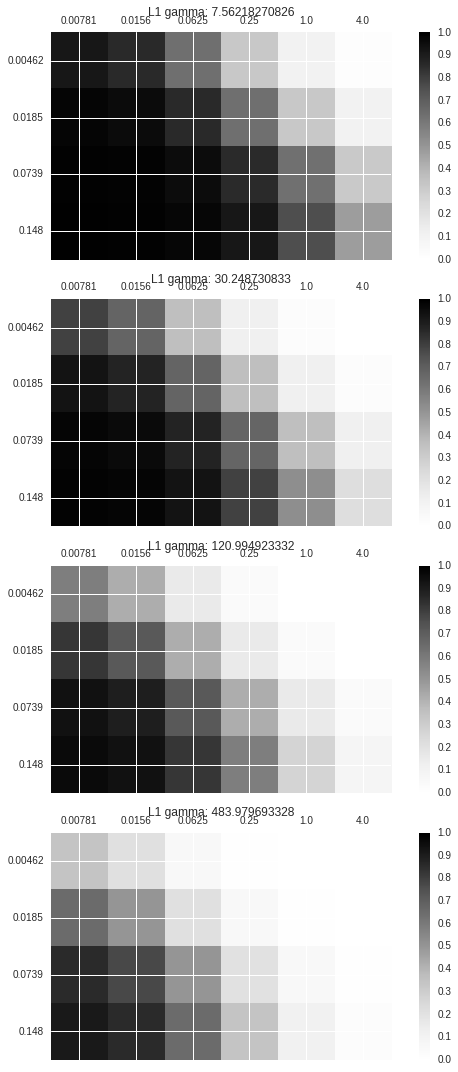

In [13]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8, 15))
for i in range(len(l1_gamma_mults)):
    ax = fig.add_subplot(len(l1_gamma_mults), 1, i+1)
    cax = ax.matshow(mean_scores[i, :, :], vmin=0, vmax=1)
    
    ax.set_yticklabels([''] + ['{:.3}'.format(g * mmd_med2) for g in l2_gamma_mults])
    ax.set_xticklabels([''] + ['{:.3}'.format(a) for a in alphas])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    fig.colorbar(cax)
    ax.set_title("L1 gamma: {}".format(l1_gamma_mults[i] * med_2))
plt.tight_layout()

Looking at these results, the best results are with the lowest alpha, lowest L1 gamma, and highest L2 gamma. So if we were really trying to solve this as best as possible, we'd maybe want to try lower alphas / lower L1 gammas / higher L2 gammas. But, whatever; let's just use the best of the ones we did try for now.

In [14]:
best_l1_gamma_i, best_l2_gamma_i, best_alpha_i = np.unravel_index(mean_scores.argmax(), mean_scores.shape)
best_l1_gamma = l1_gamma_mults[best_l1_gamma_i] * med_2
best_l2_gamma = l2_gamma_mults[best_l2_gamma_i] * mmd_med2
best_alpha = alphas[best_alpha_i]

In [16]:
best_l1_gamma_i, best_l2_gamma_i, best_alpha_i

(0, 3, 0)

In [15]:
best_l1_gamma, best_l2_gamma, best_alpha

(7.5621827082571507, 0.14778624920765476, 0.0078125)

Now, train a model on the full training set:

In [17]:
# get the training kernel
D2_mmd = mmds[best_l1_gamma_i]
np.multiply(D2_mmd, -best_l2_gamma, out=K)
np.exp(K, out=K)

ridge = KernelRidge(alpha=best_alpha, kernel='precomputed')
ridge.fit(K, mean)

KernelRidge(alpha=0.0078125, coef0=1, degree=3, gamma=None,
      kernel='precomputed', kernel_params=None)

To evaluate on new data:

In [18]:
# generate some test data from the same distribution
t_n = 100
t_mean = np.random.normal(0, 10, size=t_n)
t_var = np.random.gamma(5, size=t_n)
t_n_samp = np.random.randint(10, 500, size=t_n)
t_samps = [np.random.normal(m, v, size=s)[:, np.newaxis]
           for m, v, s in zip(t_mean, t_var, t_n_samp)]

In [19]:
# get the kernel from the training data to the test data
t_K = mmd.rbf_mmd(t_samps, samps, gammas=best_l1_gamma, squared=True,
                  Y_diag=mmk_diags[best_l1_gamma_i], n_jobs=20)
t_K *= -best_l2_gamma
np.exp(t_K, out=t_K);

RBF mean map kernel:
 50,100 of 50,100 (100%) |#############################################################| Time: 0:00:36



In [20]:
preds = ridge.predict(t_K)

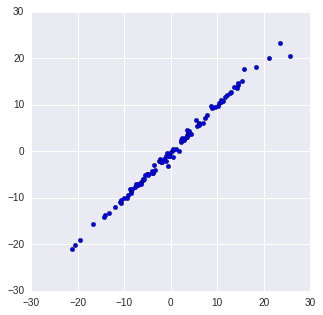

In [21]:
plt.figure(figsize=(5, 5))
plt.scatter(t_mean, preds)

Pretty good predictions!